In [1]:
!pip install -q geopandas
!pip install -q lxml
!pip install -q bs4
!pip install -q rapidfuzz
!pip install -q geopandas matplotlib contextily

In [2]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import networkx as nx
import contextily as ctx
import matplotlib.pyplot as plt
import plotly.express as px
from rapidfuzz import process

In [3]:
neighborhoods = gpd.read_file("NYCneighbourhoods.geojson")
apartments    = pd.read_csv('listings.csv', low_memory=False)
complaints    = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_ (1).csv')
population    = pd.read_excel("nyc_decennialcensusdata_2010_2020_change-core-geographies.xlsx", 
                              sheet_name="2010, 2020, and Change", 
                              skiprows= [0,1,2])

housing_prices_bronx         = pd.read_excel("rollingsales_bronx.xlsx",        skiprows= [0,1,2,3])
housing_prices_brooklyn      = pd.read_excel("rollingsales_brooklyn.xlsx",     skiprows= [0,1,2,3])
housing_prices_manhattan     = pd.read_excel("rollingsales_manhattan.xlsx",    skiprows= [0,1,2,3])
housing_prices_queens        = pd.read_excel("rollingsales_queens.xlsx",       skiprows= [0,1,2,3])
housing_prices_staten_island = pd.read_excel("rollingsales_statenisland.xlsx", skiprows= [0,1,2,3])

housing_prices = pd.concat([housing_prices_bronx,
                            housing_prices_brooklyn, 
                            housing_prices_manhattan, 
                            housing_prices_queens, 
                            housing_prices_staten_island])

## Preprocessing


#### Population
The dataset contains information on many different ways to divide NYC into neighborhoods. For this analysis we are only interested in the NTA2020 neighborhoods, and only the population data in 2020 (not 2010)

It also contains a lot of information about the population like race and age. These are irrelevant to our analysis, and only the two columns that are relevant are kept.

In [4]:
population = population[population["GeoType"] == "NTA2020"][["Name", "Pop_20"]]

#### Housing Prices
- There are a number of outliers in the housing_prices, where they were sold for 0, 1 or just a very small amount. These are dropped from the further analysis, because we assume there is more at play in those cases.
- Some of the housing sales contain multiple residential units, which could all bo rented as Airbnb's. Therefore the sale price is divided by the number of total units. Houses with no units are also dropped, seeing that it must have at least 1 to be inhabitable.

Aside from this, only the columns relevant for the analysis are kept.

In [5]:
housing_prices = housing_prices[housing_prices['SALE PRICE'] >= 100000]
housing_prices = housing_prices[housing_prices['TOTAL UNITS'] != 0]
housing_prices['AVERAGE PRICE'] = housing_prices['SALE PRICE'] / housing_prices['TOTAL UNITS']

housing_prices= housing_prices[['AVERAGE PRICE', 'NEIGHBORHOOD']]


#### Apartments
This dataset took the most time to preprocess. The full process is described in the other notebook. Here we only included the parts where data was actually changed, as to not clutter the notebook.

In [6]:
apartments['price'] = apartments['price'].replace({'\$':'', ',':''}, regex = True).astype(float)
apartments.dropna(subset=['reviews_per_month'], inplace=True)
apartments = apartments[apartments['reviews_per_month'] <= 31]
apartments = apartments[apartments['price'] <= 20000]
apartments = apartments[apartments['room_type']=='Entire home/apt']

guest_review_rate = 0.5
occupancy_rate_cap = 0.7
min_stay_duration = 3

apartments['days_booked_per_month'] = apartments['number_of_reviews_ltm'] / 12.0 * apartments['minimum_nights']
apartments[apartments['minimum_nights'] < 3]['days_booked_per_month'] = apartments['number_of_reviews_ltm'] / 12.0 * 3

apartments[apartments['days_booked_per_month'] > occupancy_rate_cap*30] = occupancy_rate_cap*30

apartments['avg_monthly_revenue'] = (apartments['days_booked_per_month'] * apartments['price']) / guest_review_rate

apartments = apartments[['id', 'latitude', 'longitude', 'avg_monthly_revenue']]

C:\Users\20183061\AppData\Local\Temp\ipykernel_21648\669029156.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apartments[apartments['minimum_nights'] < 3]['days_booked_per_month'] = apartments['number_of_reviews_ltm'] / 12.0 * 3


# Merging the data
The data from the apartments and the complaints are matched using their longitude and latitude information. This is connected using the GeoJSON, specificying the borders of each neighborhood. The apartments dataset also contains information about the neighborhoods, but because there are many ways of splitting New York into neighborhoods we decided to use latitude and longitude, so they all use the same definition.

In [7]:
geometry_ap = [Point(xy) for xy in zip(apartments['longitude'], apartments['latitude'])]
geometry_co = [Point(xy) for xy in zip(complaints['Longitude'], complaints['Latitude'])]

# Create a GeoDataFrame from the apartments DataFrame
apartments_gdf = gpd.GeoDataFrame(apartments, geometry=geometry_ap)
complaints_gdf = gpd.GeoDataFrame(complaints, geometry=geometry_co)

apartments_gdf.crs = "EPSG:4326"
complaints_gdf.crs = "EPSG:4326"

joined_ap = gpd.sjoin(apartments_gdf, neighborhoods, how="left", predicate="within")
joined_co = gpd.sjoin(complaints_gdf, neighborhoods, how="left", predicate="within")

ap_neighborhood_names = joined_ap["NTAName"]
co_neighborhood_names = joined_co["NTAName"]

apartments_with_neighborhoods = pd.concat([apartments, ap_neighborhood_names], axis=1)
complaints_with_neighborhoods = pd.concat([complaints, co_neighborhood_names], axis=1)

#### Preprocessing Complaints
- Complaints is preprocessed by checking the null values, checking what the types of offenses are, and dropping the types of complaints that are irrelevant for the safety in an Airbnb.
- Next the complaints which have a latitude and longitude that cannot be matched with a neighborhood are dropped because they cannot be used in the ret of the analysis. 
- Finally all columns that are not interesting are dropped.

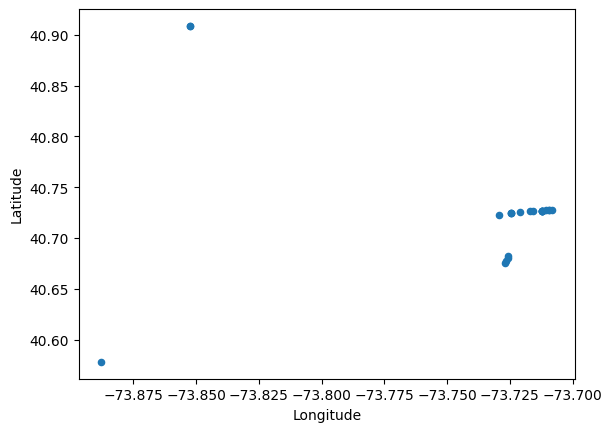

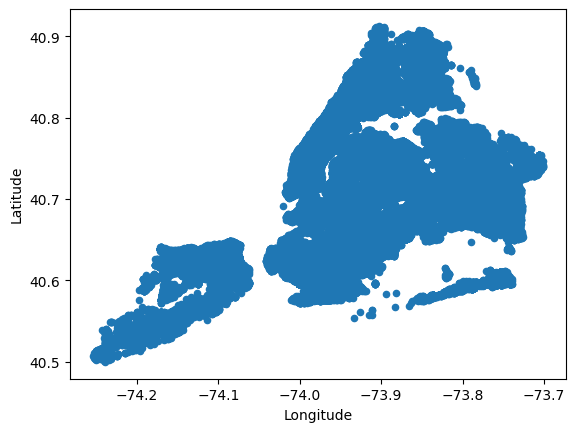

In [8]:
#Check NAN values
complaints_with_neighborhoods.isnull().sum()

complaints_with_neighborhoods["OFNS_DESC"].unique()
df_comp = complaints_with_neighborhoods[complaints_with_neighborhoods["OFNS_DESC"]!="OFFENSES INVOLVING FRAUD"]

# The points which have not  been assigned a neighborhood are dropped from the analysis. Inspecting these points shows that some of the are at 0,0 which is probably just a missing value, and others fall just outside of NYC borders.
df_no_NTA = df_comp[df_comp['NTAName'].isna()]
df_no_NTA = df_no_NTA[df_no_NTA['Latitude']>20]
df_no_NTA.plot.scatter(y="Latitude", x="Longitude")

df_comp = df_comp[df_comp['NTAName'].notna()]
df_comp.plot.scatter(y="Latitude", x="Longitude")

interesting_columns = ["CMPLNT_NUM", "OFNS_DESC", "NTAName", "Latitude", "Longitude"]
df_comp = df_comp[interesting_columns]

In [9]:
# The dataframes are renamed to match the rest of the analysis
complaints_clean = df_comp
airbnb_clean = apartments_with_neighborhoods
population = population.rename(columns = {"Name": "NTA Name", "Pop_20": "Population"})


# Neighborhood name Merging
When we compare the names from the AirBnB to the population, we see they actually match. 
There are only some more NTA's included in the population dataset. These are not of interest, because there are no airbnbs in there.
Therefore we drop those rows.

Further inspection reveals that the rows that are dropped are all parks, islands and fields. It makes sense that these have no AirBnB's.

In [10]:
correct_names = airbnb_clean["NTAName"].unique()
other_names = population["NTA Name"].unique()

population = population[population['NTA Name'].isin(correct_names)]

# print(len(set(correct_names)))
# print(len(set(other_names)))
# print(len(set(correct_names).intersection(set(other_names))))
# print(set(correct_names)-set(other_names))

Inspection of the lists of names reveals that many of them match a bit, but not perfectly. Therefore we employ guzzy string matching to find the best combinations.

In [11]:
# Create a function to find the best match for a neighborhood name
def find_best_match(name, choices):
    best_match = process.extractOne(name, choices)
    if best_match is None:
        return None
    return best_match[0] if best_match[1] >= 65 else None


In [12]:
'''
To match the housing prices the strings don't fully line up. 
Therefore we use fuzzy string comparisons to see which ones are most alike.
These are put into a dictionary where we check if the matches have been done right.
We already see that there are 251 Neighborhood names, which suggest that we should have 32 non-matches

There are only 96 matches at first, with the threshold at 65. I will lower the match to 70, this gives us 189.

'''
housing_price_names = housing_prices["NEIGHBORHOOD"].unique()
print(len(housing_price_names))
transformed_housing_names = {name: find_best_match(name.lower(), correct_names) for name in housing_price_names}

251


In [13]:
'''
Further inspection revealed a lot of the matches were not correct. These have all been corrected below.
This was done by looking at all of the matches, and seeing whether they made sense.
If a good alternative was available in the correct-names list it was used, otherwise it was set to none.
'''
#transformed_housing_names

transformed_housing_names['CITY ISLAND-PELHAM STRIP'] = 'Pelham Bay-Country Club-City Island'
transformed_housing_names['BRONXDALE'] = None
transformed_housing_names['KINGSBRIDGE HTS/UNIV HTS'] = 'Kingsbridge Heights-Van Cortlandt Village'
transformed_housing_names['KINGSBRIDGE/JEROME PARK'] = 'Kingsbridge-Marble Hill'
transformed_housing_names['COBBLE HILL-WEST'] = 'Carroll Gardens-Cobble Hill-Gowanus-Red Hook'
transformed_housing_names['DOWNTOWN-FULTON FERRY'] ='Downtown Brooklyn-DUMBO-Boerum Hill'
transformed_housing_names['DOWNTOWN-FULTON MALL'] = 'Downtown Brooklyn-DUMBO-Boerum Hill'
transformed_housing_names['DOWNTOWN-METROTECH'] = 'Downtown Brooklyn-DUMBO-Boerum Hill'
transformed_housing_names['OLD MILL BASIN'] = 'Marine Park-Mill Basin-Bergen Beach'
transformed_housing_names['SEAGATE'] = 'Coney Island-Sea Gate'
transformed_housing_names['WYCKOFF HEIGHTS'] = None
transformed_housing_names['FASHION'] = None
transformed_housing_names['HARLEM-WEST'] = 'Manhattanville-West Harlem'
transformed_housing_names['HARLEM-CENTRAL'] = 'Harlem (South)'
transformed_housing_names['HARLEM-UPPER'] = 'Harlem (North)'
transformed_housing_names['HARLEM-EAST'] = 'East Harlem (North)'
transformed_housing_names['MIDTOWN CBD'] = 'Midtown-Times Square'
transformed_housing_names['MIDTOWN WEST'] = 'Midtown-Times Square'
transformed_housing_names['SOHO'] = 'SoHo-Little Italy-Hudson Square'
transformed_housing_names['SOUTHBRIDGE'] = None
transformed_housing_names['UPPER EAST SIDE (59-79)'] ='Upper East Side-Lenox Hill-Roosevelt Island'
transformed_housing_names['UPPER EAST SIDE (79-96)'] ='Upper East Side-Lenox Hill-Roosevelt Island'
transformed_housing_names['UPPER EAST SIDE (96-110)'] ='Upper East Side-Lenox Hill-Roosevelt Island'
transformed_housing_names['UPPER WEST SIDE (59-79)'] ='Upper West Side-Manhattan Valley'
transformed_housing_names['UPPER WEST SIDE (79-96)'] ='Upper West Side-Manhattan Valley'
transformed_housing_names['UPPER WEST SIDE (96-116)'] ='Upper West Side-Manhattan Valley'
transformed_housing_names['DONGAN HILLS-COLONY'] = 'Grasmere-Arrochar-South Beach-Dongan Hills'
transformed_housing_names['DONGAN HILLS-OLD TOWN'] = 'Grasmere-Arrochar-South Beach-Dongan Hills'
transformed_housing_names['GREAT KILLS-BAY TERRACE'] = 'Great Kills-Eltingville'
transformed_housing_names['NEW BRIGHTON-ST. GEORGE'] = 'St. George-New Brighton'
transformed_housing_names['NEW DORP-BEACH']= 'New Dorp-Midland Beach'
transformed_housing_names['New Dorp-Midland Beach'] = 'New Dorp-Midland Beach'
transformed_housing_names['OAKWOOD-BEACH'] = 'Oakwood-Richmondtown'
transformed_housing_names['ROSSVILLE-PORT MOBIL'] ='Arden Heights-Rossville'
transformed_housing_names['ROSSVILLE-RICHMOND VALLEY'] ='Arden Heights-Rossville'
transformed_housing_names['WASHINGTON HEIGHTS LOWER'] ='Washington Heights (South)'
transformed_housing_names['WASHINGTON HEIGHTS UPPER'] ='Washington Heights (North)'

In [14]:
housing_prices["NTA Name"] = housing_prices["NEIGHBORHOOD"].map(transformed_housing_names)

# Now 222 of the NTA Names are matched. The rest had no match.
count = sum(value is not None for value in transformed_housing_names.values())
print(count)

222


In [15]:
'''
Here is is checked which of the files is the bottleneck in the amount of Neighborhoods taken into account.
It turns out this is the housing_prices dataset.
'''

airbnb_clean["NTAName"].unique()
complaints_clean["NTAName"].unique()

set1 = set(airbnb_clean["NTAName"].unique())
set2 = set(complaints_clean["NTAName"].unique())
set3 = set(population["NTA Name"].unique())
set4 = set(housing_prices["NTA Name"].unique())

all_NTA = set1.intersection(set2, set3, set4)

# print(len(set1))
# print(len(set2))
# print(len(set3))
# print(len(set4))
# print(len(all_NTA))

# print(len(set1.intersection(set4)))


housing_prices = housing_prices.dropna()

Here the graph is created. The nodes are added, with their connections. The attributes of interest are added to the nodes.

In [16]:
graph = nx.Graph()

for neighborhood in all_NTA:
    graph.add_node(neighborhood)
    graph.nodes[neighborhood]["population"] = population.loc[population['NTA Name'] == neighborhood, 'Population'].values[0]

for index, complaint_row in complaints_clean.iterrows():
    indexing = "complaint"+str(index)
    graph.add_node(indexing)
    graph.nodes[indexing]["complaint_type"] = complaint_row["OFNS_DESC"]
    graph.add_edge(indexing, complaint_row["NTAName"], label="complaint_is_in")
    
for index, airbnb_listing in airbnb_clean.iterrows():
    indexing = "listing"+str(index)
    graph.add_node(indexing)
    graph.add_edge(indexing, airbnb_listing["NTAName"], label="airbnb_is_in")
    
    graph.nodes[indexing]["avg_monthly_revenue"] = airbnb_listing["avg_monthly_revenue"]

    
for index, sale in housing_prices.iterrows():
    indexing = "sale"+str(index)
    graph.add_node(indexing)
    graph.add_edge(indexing, sale["NTA Name"], label="sale_is_in")
    
    graph.nodes[indexing]["price"] = sale["AVERAGE PRICE"]

    

For every neighborhood node their neighbors are analyzed. 
- For the sale prices the average sale_price is calculated. This is then multiplied by the cost_factor of a mortgage, and divided by 12 to get the monthly costs. If there are too little sales in the neighborhood to base the prediction on it is not taken into account
- For the crimes the amount of crimes is divided by the population of the nieghborhood to get the crime rate per capita. This is then scaled using the mean and standard deviation of crime rates
- For the airbnbs, the average monthly revenue is taken into account. If there are too little airbnbs to base this estimation on, we do not take the neighborhood as an option.
- Then the ROI is calculated by taking the revenue - profit and dividing it by the total costs.
- The scaling factor is calculated by multiplying the crime_weighting with the scaled crime. 
- Multiplying these gives us the final score, from which the maximum 5 are returned.

In [22]:
crime_weighting = 0.1
cost_factor = 0.03

dropped_nb =0

def get_crime_rates(node):
    neighbors_crimes = [neighbor for neighbor in graph.neighbors(node) if graph.edges[node, neighbor]["label"] == "complaint_is_in"]
    
    crime_rate = len(neighbors_crimes) / graph.nodes[node]["population"]
    crime_track.append(crime_rate)
    return crime_rate

crime_rate_list = [get_crime_rates(n) for n in all_NTA]


In [23]:
#With these two statistics we can normalize the crime rates.
mean_crime_track = np.mean(crime_rate_list)
std_crime_track  = np.std(crime_rate_list)

In [24]:
crime_weighting = 0.1
cost_factor = 0.03

dropped_nb =0

def investment_rating(node):
    neighbors_sale_prices = [graph.nodes[neighbor]["price"] for neighbor in graph.neighbors(node) if graph.edges[node, neighbor]["label"] == "sale_is_in"]
    
    if len(neighbors_sale_prices) < 20:
        #print(f"{node} returned due to too little housing sales")
        return -10000
    
    average_sale_price = np.mean(neighbors_sale_prices)
    costs = average_sale_price * cost_factor /12
    
    neighbors_crimes = [neighbor for neighbor in graph.neighbors(node) if graph.edges[node, neighbor]["label"] == "complaint_is_in"]
    
    crime_rate = len(neighbors_crimes) / graph.nodes[node]["population"]
    scaled_crime_rate = (crime_rate - mean_crime_track) / std_crime_track


    neighbors_airbnb = [graph.nodes[neighbor]["avg_monthly_revenue"] for neighbor in graph.neighbors(node) if graph.edges[node, neighbor]["label"] == "airbnb_is_in"]
    
    if len(neighbors_airbnb) <20:
        #print(f"{node} returned due to too little AirBnBs")
        return -10000
    
    #Revenue is calculated as the mean revenue of all Airbnbs in a neighborhood
    revenue = np.mean(neighbors_airbnb)
    roi            = 12*(revenue - costs)/average_sale_price
    scaling_factor = (1 - crime_weighting * scaled_crime_rate)
    
    #print(f"NB {node} pop {graph.nodes[node]['population']} rev {revenue} costs {costs} ROI {roi} sc_cr_rt {scaled_crime_rate} sc_fc {scaling_factor} score{roi * scaling_factor}")
    # If the ROI is positive, you want it to go up with a high scaling factor, If it is negative you also want it to go up, so you have to make a case distinction
    if roi>0:
        return roi * scaling_factor
    if roi<0:
        return roi / scaling_factor


nb_nodes = [n for n in all_NTA]
nodes_with_max_combination = max(nb_nodes, key=investment_rating)


top_nodes = sorted(nb_nodes, key=investment_rating, reverse=True)[:5]

print(top_nodes)


['St. George-New Brighton', 'West New Brighton-Silver Lake-Grymes Hill', 'East Elmhurst', 'New Dorp-Midland Beach', 'Chinatown-Two Bridges']


Finally we visualize the best neighborhoods to get a sense of where they are

In [25]:
neighborhoods_to_plot = top_nodes
data = gpd.read_file("NYCneighbourhoods.geojson")
filtered_data = data[data['NTAName'].isin(neighborhoods_to_plot)]

fig = px.choropleth_mapbox(
    filtered_data,
    geojson=filtered_data.geometry,
    locations=filtered_data.index,
    color_continuous_scale='Viridis',
    mapbox_style='carto-positron',
    center={'lat': 40.7128, 'lon': -74.0060},
    zoom=10
)

# Update layout settings
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

# Show the plot
fig.show()